In [9]:
!pip install transformers -U
!pip install accelerate -U

In [10]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re

In [11]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')
java_file_path = '/content/drive/MyDrive/Wajid Ali/FYP/Dataset/java.csv'
python_file_path = '/content/drive/MyDrive/Wajid Ali/FYP/Dataset/python.csv'
pharo_file_path = '/content/drive/MyDrive/Wajid Ali/FYP/Dataset/pharo.csv'
java_df = pd.read_csv(java_file_path)
python_df = pd.read_csv(python_file_path)
pharo_df = pd.read_csv(pharo_file_path)
print(java_df.head)
print(python_df.head)
print(pharo_df.head)

#just for faster training
#df = df[:500]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<bound method NDFrame.head of        comment_sentence_id                           class  \
0                     5522  CFileTypesPreferenceBlock.java   
1                     5523  CFileTypesPreferenceBlock.java   
2                     5524  CFileTypesPreferenceBlock.java   
3                     5525  CFileTypesPreferenceBlock.java   
4                     5526  CFileTypesPreferenceBlock.java   
...                    ...                             ...   
73880                 5108               VScrollTable.java   
73881                 5109               VScrollTable.java   
73882                 5110               VScrollTable.java   
73883                 5111               VScrollTable.java   
73884                 5112               VScrollTable.java   

                                        comment_sentence  partition  \
0      /*\n * Preference 

Replaced **Expand** category with **java_Expand** because there is already a category in **python_df** with the same name

In [12]:
java_df['category'] = java_df['category'].replace('Expand', 'java_Expand')

#**Function for selecting only 100 instances for each category**

In [13]:
#Function for selecting 100 instances for each of the unique categories in the category column
#80 for training and 20 for testing
def sample_data_by_category(df, num_total=100, num_train=80, num_test=20):
    """
    Samples data to ensure a balanced dataset with a specified number of total instances per category,
    divided into training and testing based on partition values.

    Parameters:
    df (pd.DataFrame): Input DataFrame with 'category' and 'partition' columns.
    num_total (int): Total number of samples per category.
    num_train (int): Number of training samples (partition=1) per category.
    num_test (int): Number of testing samples (partition=0) per category.

    Returns:
    pd.DataFrame: A DataFrame balanced according to the specified criteria.
    """
    categories = df['category'].unique()
    sampled_df = pd.DataFrame()

    for category in categories:
        # Filter the DataFrame for the current category
        category_df = df[df['category'] == category]

        # Ensure there are enough instances to sample from
        if len(category_df) < num_total:
            print(f"Not enough data for category {category}, needed {num_total}, found {len(category_df)}")
            continue

        # Split by partition and sample accordingly
        train_df = category_df[category_df['partition'] == 1]
        test_df = category_df[category_df['partition'] == 0]

        if len(train_df) < num_train or len(test_df) < num_test:
            print(f"Not enough train/test data for category {category}. Training needed: {num_train}, found: {len(train_df)}. Testing needed: {num_test}, found: {len(test_df)}.")
            continue

        train_samples = train_df.sample(n=num_train, replace=False)
        test_samples = test_df.sample(n=num_test, replace=False)

        # Concatenate the train and test samples
        samples = pd.concat([train_samples, test_samples])

        # Append the samples to the sampled_df DataFrame
        sampled_df = pd.concat([sampled_df, samples])

    # Reset the index of the final sampled DataFrame
    sampled_df.reset_index(drop=True, inplace=True)

    return sampled_df

In [14]:
print(java_df['category'].unique())
print(java_df['category'].nunique())
print(java_df['partition']==0)
# java_df = sample_data_by_category(java_df)
print(java_df)

['summary' 'Ownership' 'java_Expand' 'usage' 'Pointer' 'deprecation'
 'rational']
7
0        False
1        False
2        False
3        False
4        False
         ...  
73880     True
73881     True
73882     True
73883     True
73884     True
Name: partition, Length: 73885, dtype: bool
       comment_sentence_id                           class  \
0                     5522  CFileTypesPreferenceBlock.java   
1                     5523  CFileTypesPreferenceBlock.java   
2                     5524  CFileTypesPreferenceBlock.java   
3                     5525  CFileTypesPreferenceBlock.java   
4                     5526  CFileTypesPreferenceBlock.java   
...                    ...                             ...   
73880                 5108               VScrollTable.java   
73881                 5109               VScrollTable.java   
73882                 5110               VScrollTable.java   
73883                 5111               VScrollTable.java   
73884                 511

In [15]:
print(python_df['category'].unique())
print(python_df['category'].nunique())
print(python_df['partition']==0)
# python_df = sample_data_by_category(python_df)
print(python_df)

['Usage' 'Parameters' 'DevelopmentNotes' 'Expand' 'Summary']
5
0         True
1        False
2         True
3        False
4         True
         ...  
12770    False
12771     True
12772    False
12773     True
12774     True
Name: partition, Length: 12775, dtype: bool
       comment_sentence_id            class  \
0                        1      AccessMixin   
1                        2      AccessMixin   
2                        5   AmbiguityError   
3                        7    AppConfigStub   
4                        8    AppConfigStub   
...                    ...              ...   
12770                 5958         Response   
12771                 5929         AuthBase   
12772                 5931    InvalidHeader   
12773                 5933  PreparedRequest   
12774                 5934  PreparedRequest   

                                        comment_sentence  partition  \
0      abstract cbv mixin that gives access mixins th...          0   
1                    

In [16]:
print(pharo_df['category'].unique())
print(pharo_df['category'].nunique())
print(pharo_df['partition']==0)
# pharo_df = sample_data_by_category(pharo_df)
print(pharo_df)

['Keyimplementationpoints' 'Example' 'Responsibilities' 'Classreferences'
 'Intent' 'Keymessages' 'Collaborators']
7
0         True
1        False
2         True
3        False
4         True
         ...  
12350     True
12351     True
12352     True
12353     True
12354     True
Name: partition, Length: 12355, dtype: bool
       comment_sentence_id                       class  \
0                        1   BlAnchorRelativeToElement   
1                        3         BlArrowheadExamples   
2                     1027  GtDiagrammerEllipseStencil   
3                     1029        GtDiagrammerExamples   
4                        6      BlArrowheadSimpleArrow   
...                    ...                         ...   
12350                 4026                   WAFormTag   
12351                 3867             WAComboResponse   
12352                 3901                    WACookie   
12353                 3837          WABulkReapingCache   
12354                 3838          

In [17]:
df = pd.concat([java_df, python_df, pharo_df], ignore_index=True)
df.head(5)
print(df['partition']==0)

0        False
1        False
2        False
3        False
4        False
         ...  
99010     True
99011     True
99012     True
99013     True
99014     True
Name: partition, Length: 99015, dtype: bool


In [18]:
categories = df['category'].unique()
categories

array(['summary', 'Ownership', 'java_Expand', 'usage', 'Pointer',
       'deprecation', 'rational', 'Usage', 'Parameters',
       'DevelopmentNotes', 'Expand', 'Summary', 'Keyimplementationpoints',
       'Example', 'Responsibilities', 'Classreferences', 'Intent',
       'Keymessages', 'Collaborators'], dtype=object)

In [19]:
df['category'].nunique()

19

**Split the dataset into training and testing data**

In [20]:
# Filter training and test data
test_data = df[df['partition'] == 0]
train_data = df[df['partition'] == 1]
print(f"Size of the data frame: {df.size}")
df = train_data
print(f"Size of the training dataset: {train_data.size}")
print(f"Size of the test dataset: {test_data.size}")
combined_size = train_data.size + test_data.size
print(f"Combined size of training and testing dataset: {combined_size}")

Size of the data frame: 594090
Size of the training dataset: 119352
Size of the test dataset: 474738
Combined size of training and testing dataset: 594090


#**Preprocessing of the dataset**

In [21]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Replace non-alphanumeric characters with spaces
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Remove stopwords and lemmatize
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    return text



df['combo'] = df['class'] + " " + df['comment_sentence']  # Concatenate 'class' and 'comment_sentence'
df['combo'] = df['combo'].apply(preprocess_text)
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


   comment_sentence_id                           class  \
0                 5522  CFileTypesPreferenceBlock.java   
1                 5523  CFileTypesPreferenceBlock.java   
2                 5524  CFileTypesPreferenceBlock.java   
3                 5525  CFileTypesPreferenceBlock.java   
4                 5526  CFileTypesPreferenceBlock.java   

                                    comment_sentence  partition  \
0  /*\n * Preference block that encapsulates the ...          1   
1   // Create the table viewer for file associations          1   
2                          // Create the button pane          1   
3                                      // New button          1   
4                                   // Remove button          1   

   instance_type category                                              combo  
0              1  summary  cfiletypespreferenceblock java preference bloc...  
1              1  summary  cfiletypespreferenceblock java create table vi...  
2          

#**Preprocess the test data as well**

In [22]:
test_data['combo'] = test_data['class'] + " " + test_data['comment_sentence']  # Concatenate 'class' and 'comment_sentence'
test_data['combo'] = test_data['combo'].apply(preprocess_text)
print(test_data.head())

      comment_sentence_id                   class    comment_sentence  \
1525                 7047  ImmutableRangeSet.java  @link Set#hashCode   
1526                 7048  ImmutableRangeSet.java         @code asSet   
1527                 7049  ImmutableRangeSet.java        @code (1..5)   
1528                 7050  ImmutableRangeSet.java   @code a.equals(b)   
1529                 7051  ImmutableRangeSet.java        @code [4..4)   

      partition  instance_type category  \
1525          0              0  summary   
1526          0              0  summary   
1527          0              0  summary   
1528          0              0  summary   
1529          0              0  summary   

                                         combo  
1525  immutablerangeset java link set hashcode  
1526         immutablerangeset java code asset  
1527           immutablerangeset java code 1 5  
1528       immutablerangeset java code equal b  
1529           immutablerangeset java code 4 4  


In [23]:
train_counts = train_data['category'].value_counts()
test_counts = test_data['category'].value_counts()
print(train_counts)
print(test_counts)

category
summary                    2117
Ownership                  2116
Pointer                    2116
java_Expand                2114
usage                      2114
rational                   2114
deprecation                2113
Parameters                  518
Usage                       517
DevelopmentNotes            516
Expand                      516
Summary                     516
Keyimplementationpoints     359
Responsibilities            359
Collaborators               359
Keymessages                 358
Example                     357
Classreferences             357
Intent                      356
Name: count, dtype: int64
category
deprecation                8442
usage                      8441
java_Expand                8441
rational                   8441
Ownership                  8439
Pointer                    8439
summary                    8438
Expand                     2039
DevelopmentNotes           2039
Summary                    2039
Usage                      2

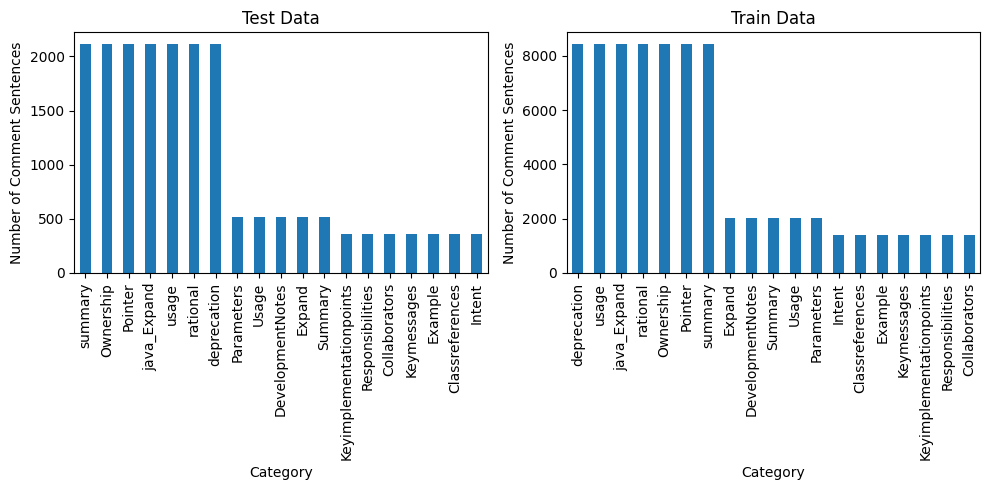

In [24]:
# Plot bar graphs for training and test data
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
train_counts.plot(kind='bar')
plt.title('Test Data')
plt.xlabel('Category')
plt.ylabel('Number of Comment Sentences')

plt.subplot(1, 2, 2)
test_counts.plot(kind='bar')
plt.title('Train Data')
plt.xlabel('Category')
plt.ylabel('Number of Comment Sentences')

plt.tight_layout()
plt.show()

<Axes: ylabel='Frequency'>

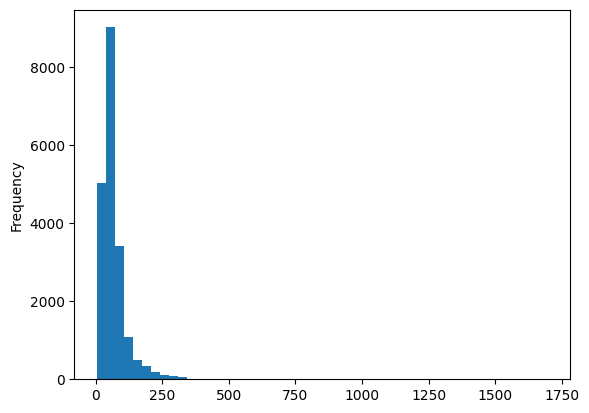

In [25]:
df['combo'].str.len().plot.hist(bins=50)

In [26]:
# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [27]:
class CommentDataset(Dataset):
    def __init__(self, combos, labels, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.combos = combos
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.combos)

    def __getitem__(self, idx):
        combo = str(self.combos[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            combo,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'combo_text': combo,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [28]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    #epochs to be increased in future 20/03/2024
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy='steps',
    logging_dir='./logs',
    logging_steps=1000
)

#**We will use all 19 categories for trainging the model**

In [29]:
categories

array(['summary', 'Ownership', 'java_Expand', 'usage', 'Pointer',
       'deprecation', 'rational', 'Usage', 'Parameters',
       'DevelopmentNotes', 'Expand', 'Summary', 'Keyimplementationpoints',
       'Example', 'Responsibilities', 'Classreferences', 'Intent',
       'Keymessages', 'Collaborators'], dtype=object)

In [30]:
import os

# Loop over categories
for category in categories:
    print(f"Training for category: {category}")
    train_data['label'] = (train_data['category'] == category).astype(int)
    test_data['label'] = (test_data['category'] == category).astype(int)

    # Create datasets
    train_dataset = CommentDataset(train_data['combo'].to_numpy(), train_data['label'].to_numpy(), tokenizer)
    test_dataset = CommentDataset(test_data['combo'].to_numpy(), test_data['label'].to_numpy(), tokenizer)  # Corrected from 'category' to 'combo'

    if len(train_dataset) > 0 and len(test_dataset) > 0:
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset
        )

        trainer.train()

        # Define the directory to save the model
        model_directory = f"/content/drive/MyDrive/Wajid Ali/FYP/Models/{category}_classifier"

        # Create the directory if it does not exist
        if not os.path.exists(model_directory):
            os.makedirs(model_directory)

        # Save the model
        model.save_pretrained(model_directory)
        print(f"Model for {category} saved at {model_directory}")
    else:
        print(f"Skipping category {category} due to insufficient data.")


Training for category: summary


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for summary saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/summary_classifier
Training for category: Ownership


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for Ownership saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/Ownership_classifier
Training for category: java_Expand


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for java_Expand saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/java_Expand_classifier
Training for category: usage


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for usage saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/usage_classifier
Training for category: Pointer


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for Pointer saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/Pointer_classifier
Training for category: deprecation


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for deprecation saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/deprecation_classifier
Training for category: rational


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for rational saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/rational_classifier
Training for category: Usage


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for Usage saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/Usage_classifier
Training for category: Parameters


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for Parameters saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/Parameters_classifier
Training for category: DevelopmentNotes


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for DevelopmentNotes saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/DevelopmentNotes_classifier
Training for category: Expand


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for Expand saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/Expand_classifier
Training for category: Summary


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for Summary saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/Summary_classifier
Training for category: Keyimplementationpoints


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for Keyimplementationpoints saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/Keyimplementationpoints_classifier
Training for category: Example


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for Example saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/Example_classifier
Training for category: Responsibilities


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for Responsibilities saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/Responsibilities_classifier
Training for category: Classreferences


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for Classreferences saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/Classreferences_classifier
Training for category: Intent


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for Intent saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/Intent_classifier
Training for category: Keymessages


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for Keymessages saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/Keymessages_classifier
Training for category: Collaborators


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Model for Collaborators saved at /content/drive/MyDrive/Wajid Ali/FYP/Models/Collaborators_classifier


In [ ]:
# # Then, when setting up for training within the category loop, ensure you're selecting the correct subsets:
# for category in categories:
#     print(f"Training for category: {category}")
#     # Create a label column for the current category in both training and test sets
#     train_data['label'] = (train_data['category'] == category).astype(int)
#     test_data['label'] = (test_data['category'] == category).astype(int)

#     # Create datasets
#     train_dataset = CommentDataset(train_data['combo'].to_numpy(), train_data['label'].to_numpy(), tokenizer)
#     test_dataset = CommentDataset(test_data['combo'].to_numpy(), test_data['label'].to_numpy(), tokenizer)

#     # Initialize model and trainer here as before, then train
#     # Ensure the dataset is not empty
#     if len(train_dataset) > 0 and len(test_dataset) > 0:
#         model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
#         trainer = Trainer(
#             model=model,
#             args=training_args,
#             train_dataset=train_dataset,
#             eval_dataset=test_dataset
#         )

#         trainer.train()
#         model.save_pretrained(f"./{category}_model")
#     else:
#         print(f"Skipping category {category} due to insufficient data.")